# 三、AQI时序预测模型构建

## （一）数据清洗与特征选择
*******

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

df_main = pd.read_csv("AQI_prediction_dataset.csv")
df_main.head()

,Date,PM2.5,PM10,NO2,NOx,CO,SO2,O3,temp,max_temp,min_temp,humid,visible,wind,AQI
0,01-01-2016,56.40,95.08,51.73,34.31,0.69,7.44,55.96,20.1,28.4,15.7,54.0,6.0,3.0,101
1,02-01-2016,53.69,93.92,73.09,54.77,0.76,8.67,34.06,20.8,28.3,12.9,45.0,6.3,1.1,92
2,03-01-2016,62.35,99.34,77.77,55.60,0.96,9.10,47.62,21.4,29.0,13.7,45.0,6.3,0.4,108
3,04-01-2016,64.96,104.62,77.07,50.81,0.89,8.87,50.62,21.5,29.0,15.2,47.0,6.9,2.2,109
4,05-01-2016,70.15,105.12,79.43,56.05,0.85,9.41,36.94,20.9,28.4,14.7,51.0,6.3,1.1,114



**将日期字符串转化为datetime64[ns]类型，使得可以更方便地在后续的时间序列分析中使用。**

In [3]:
df_main["Date"] = pd.to_datetime(df_main["Date"], format="%d-%m-%Y")
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1623 non-null   datetime64[ns]
 1   PM2.5     1623 non-null   float64       
 2   PM10      1623 non-null   float64       
 3   NO2       1623 non-null   float64       
 4   NOx       1623 non-null   float64       
 5   CO        1623 non-null   float64       
 6   SO2       1623 non-null   float64       
 7   O3        1623 non-null   float64       
 8   temp      1623 non-null   float64       
 9   max_temp  1623 non-null   float64       
 10  min_temp  1623 non-null   float64       
 11  humid     1623 non-null   float64       
 12  visible   1623 non-null   float64       
 13  wind      1623 non-null   float64       
 14  AQI       1623 non-null   int64         
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 190.3 KB


***
**热力图查看AQI与各空气污染物关系**

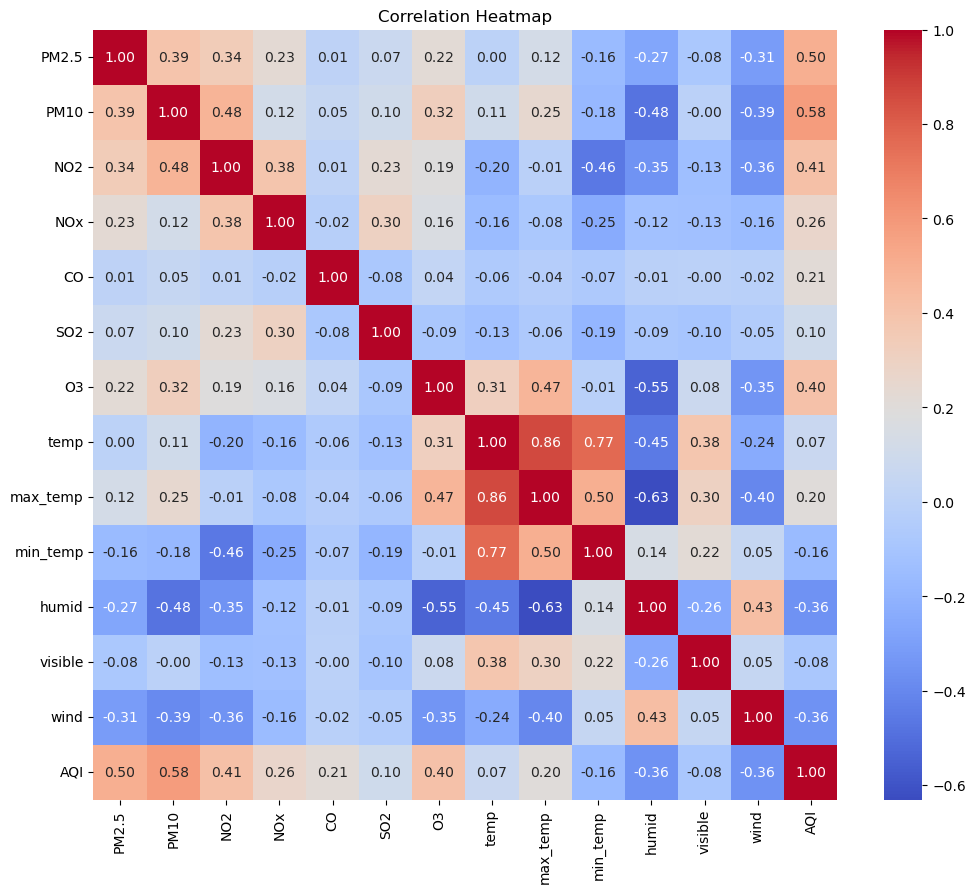

In [4]:
df_main_no_date = df_main.drop('Date', axis=1)

# 计算相关性矩阵
correlation_matrix = df_main_no_date.corr()

# 绘制热力图
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

***
**选择PM2.5 PM10 NO2	NOx	CO	SO2	O3	temp max_temp min_temp	humid visible wind 作为数据特征**


In [96]:
df_x = df_main.iloc[:, 0:13]  # 假设前13列是特征
df_y = df_main[['Date', 'AQI']]
df_x.head(5)

,Date,PM2.5,PM10,NO2,NOx,CO,SO2,O3,temp,max_temp,min_temp,humid,visible
0,2016-01-01,56.40,95.08,51.73,34.31,0.69,7.44,55.96,20.1,28.4,15.7,54.0,6.0
1,2016-01-02,53.69,93.92,73.09,54.77,0.76,8.67,34.06,20.8,28.3,12.9,45.0,6.3
2,2016-01-03,62.35,99.34,77.77,55.60,0.96,9.10,47.62,21.4,29.0,13.7,45.0,6.3
3,2016-01-04,64.96,104.62,77.07,50.81,0.89,8.87,50.62,21.5,29.0,15.2,47.0,6.9
4,2016-01-05,70.15,105.12,79.43,56.05,0.85,9.41,36.94,20.9,28.4,14.7,51.0,6.3


In [31]:
df_y.head(5)

,Date,AQI
0,2016-01-01,101
1,2016-01-02,92
2,2016-01-03,108
3,2016-01-04,109
4,2016-01-05,114


***
## （二）模型训练集与测试集划分
******

**将原数据集的80%作为训练集，20%作为测试集**

In [107]:
# 将数据拆分为训练集和测试集
split_index = int(0.8 * len(df_main))  # 80% 用于训练，20% 用于测试

df_x_train = df_x.iloc[:split_index, :]
df_y_train = df_y.iloc[:split_index, :]

df_x_test = df_x.iloc[split_index:, :]
df_y_test = df_y.iloc[split_index:, :]

# 将数据集保存为CSV文件
df_x_train.to_csv("train_x.csv", index=False)
df_y_train.to_csv("train_y.csv", index=False)
df_x_test.to_csv("test_x.csv", index=False)
df_y_test.to_csv("test_y.csv", index=False)

x_train = df_x_train.drop(['Date'], axis = 1)
y_train = df_y_train["AQI"]
x_test = df_x_test.drop(['Date'], axis = 1)
y_test = df_y_test["AQI"]

**模型数据标准化与归一化**

In [108]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(np.array(y_train).reshape(-1,1))
y_test = sc_y.transform(np.array(y_test).reshape(-1,1))

**标准化后数据**

In [82]:
x_train[:5]

array([[ 0.64452375,  0.15265131,  1.53397359,  0.88701906, -0.17785498,
         0.98591707,  1.12788241, -1.8410119 , -0.75386963, -1.74104538,
        -0.54728196, -0.97174871],
       [ 0.54101309,  0.12322334,  3.15079158,  2.18525119, -0.14482841,
         1.51557503, -0.06419501, -1.54318259, -0.78787032, -2.90596254,
        -1.12831053, -0.4973565 ],
       [ 0.87178884,  0.26072297,  3.50503822,  2.23791652, -0.05046676,
         1.70074   ,  0.6739132 , -1.28790033, -0.54986551, -2.57312907,
        -1.12831053, -0.4973565 ],
       [ 0.97147991,  0.39467094,  3.45205261,  1.93398046, -0.08349334,
         1.60169827,  0.83721148, -1.24535329, -0.54986551, -1.9490663 ,
        -0.99919307,  0.45142793],
       [ 1.16971618,  0.40735541,  3.6306898 ,  2.26647002, -0.10236567,
         1.83423103,  0.09257134, -1.50063555, -0.75386963, -2.15708722,
        -0.74095815, -0.4973565 ]])

In [83]:
y_train[:5]

array([[ 0.17883525],
       [-0.04953744],
       [ 0.35645846],
       [ 0.3818332 ],
       [ 0.50870692]])

***
## （三）预测模型选择与训练
***

> ### ①多元线性回归模型(MLR)

In [109]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

***
> **MLR模型预测结果**


In [110]:
y_prediction =  regressor.predict(x_test)
y_test_stand = y_test
y_prediction_stand = y_prediction
y_test = sc_y.inverse_transform(y_test)
y_prediction = sc_y.inverse_transform(y_prediction)

result = pd.DataFrame()
result["ACTUAL AQI"] = y_test.flatten()
result["PREDICTED AQI"] = y_prediction
result["DIFFERENCE"] = result["ACTUAL AQI"] - result["PREDICTED AQI"]
result["PERCENTAGE ERROR"] = ( abs(result["ACTUAL AQI"] - result["PREDICTED AQI"] ) / result["ACTUAL AQI"] ) * 100
result.head(15)

,ACTUAL AQI,PREDICTED AQI,DIFFERENCE,PERCENTAGE ERROR
0,50.0,52.405428,-2.405428,4.810856
1,52.0,63.171489,-11.171489,21.483633
2,68.0,64.378722,3.621278,5.325409
3,70.0,64.132717,5.867283,8.381833
4,59.0,55.349071,3.650929,6.188015
5,51.0,53.608991,-2.608991,5.115669
6,61.0,65.889212,-4.889212,8.015101
7,67.0,66.766868,0.233132,0.347959
8,65.0,65.194460,-0.194460,0.299169
9,74.0,62.123186,11.876814,16.049748


***
> **MLR模型评价**

In [111]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
score = r2_score(y_test_stand,y_prediction_stand)
mean_error = mean_squared_error(y_test_stand,y_prediction_stand)
mae = mean_absolute_error(y_test_stand,y_prediction_stand)
print("R2 SCORE（决定系数）:", score)
print("mean_sqrd_error（均方误差）: ", mean_error)
print("Root mean squared error（均方根误差）:",np.sqrt(mean_error))
print("Mean Absolute error（平均绝对误差）：", mae)

R2 SCORE（决定系数）: 0.8158947552296449
mean_sqrd_error（均方误差）:  0.047328897674621444
Root mean squared error（均方根误差）: 0.21755205738999905
Mean Absolute error（平均绝对误差）： 0.16482457853456733


> **决定系数 为 0.8159，表明模型相对较好地解释了目标变量的方差。**

> **均方误差为 0.0473，表示模型的预测值与实际值之间的平方差相对较小。**

> **均方根误差为 0.2176，表示模型的预测值与实际值之间的平均距离相对较小。**

> **平均绝对误差为 0.1648，表示模型的平均预测误差相对较小。**

> **总体而言，模型在提供的评估指标下表现良好。**

***
> **MLR模型结果曲线**


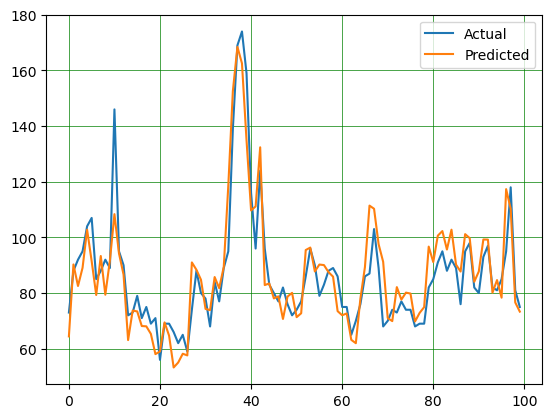

In [157]:
df1 = pd.DataFrame({'Actual': y_test[50:150].flatten(), 'Predicted': y_prediction[50:150].flatten()})
df1.plot(kind='line')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

**从模型预测结果可以发现，多元线性回归模型在AQI的时序预测上有较好的表现**

***
> ### ②随机森林模型(RF)

**数据处理与特征选择与MLR类似，这里不再赘述**

>**RF模型训练:**

In [139]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(x_train_fs,y_train)

RandomForestRegressor()

***
>**RF模型结果:**

In [140]:
y_prediction =  regressor.predict(x_test_fs)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
score = r2_score(y_test_stand,y_prediction)
mean_error = mean_squared_error(y_test_stand,y_prediction)
mae = mean_absolute_error(y_test_stand,y_prediction)
print("R2 SCORE（决定系数）:", score)
print("mean_sqrd_error（均方误差）: ", mean_error)
print("Root mean squared error（均方根误差）:",np.sqrt(mean_error))
print("Mean Absolute error（平均绝对误差）：", mae)

R2 SCORE（决定系数）: 0.8108518920185419
mean_sqrd_error（均方误差）:  0.04862529288162989
Root mean squared error（均方根误差）: 0.22051143480924043
Mean Absolute error（平均绝对误差）： 0.1711327370227373


> **决定系数 为 0.8109，表明模型相对较好地解释了目标变量的方差。**

> **均方误差为 0.04863，表示模型的预测值与实际值之间的平方差相对较小。**

> **均方根误差为 0.2205，表示模型的预测值与实际值之间的平均距离相对较小。**

> **平均绝对误差为 0.1711，表示模型的平均预测误差相对较小。**

> **总体而言，模型在提供的评估指标下表现良好。**

In [141]:
y_prediction = y_prediction.reshape(-1, 1)
y_prediction = sc_y.inverse_transform(y_prediction)

result = pd.DataFrame()
result["ACTUAL AQI"] = y_test.flatten()
result["PREDICTED AQI"] = y_prediction
result["DIFFERENCE"] = result["ACTUAL AQI"] - result["PREDICTED AQI"]
result["PERCENTAGE ERROR"] = ( abs(result["ACTUAL AQI"] - result["PREDICTED AQI"] ) / result["ACTUAL AQI"] ) * 100
result.head(15)

,ACTUAL AQI,PREDICTED AQI,DIFFERENCE,PERCENTAGE ERROR
0,50.0,52.13,-2.13,4.260000
1,52.0,59.96,-7.96,15.307692
2,68.0,66.96,1.04,1.529412
3,70.0,62.65,7.35,10.500000
4,59.0,55.59,3.41,5.779661
5,51.0,57.27,-6.27,12.294118
6,61.0,66.24,-5.24,8.590164
7,67.0,67.26,-0.26,0.388060
8,65.0,66.77,-1.77,2.723077
9,74.0,64.78,9.22,12.459459


>**RF模型结果曲线**

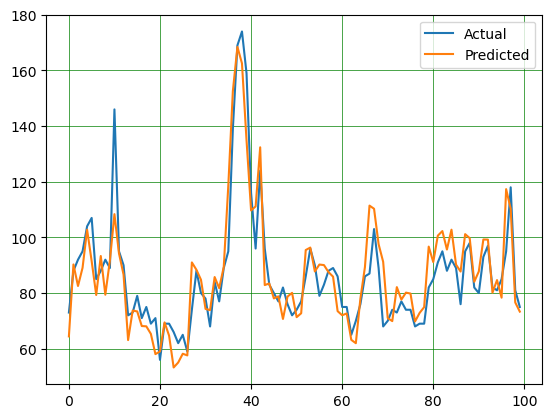

In [156]:
df1 = pd.DataFrame({'Actual': y_test[50:150].flatten(), 'Predicted': y_prediction[50:150].flatten()})
df1.plot(kind='line')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

***
> ### ②支持向量机模型模型(SVR)

> **SVR模型训练:**

In [144]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(x_train,y_train)

SVR()

> **SVR模型结果：**

In [147]:
y_prediction =  regressor.predict(x_test)

score = r2_score(y_test_stand,y_prediction)
mean_error = mean_squared_error(y_test_stand,y_prediction)
mae = mean_absolute_error(y_test_stand,y_prediction)

print("R2 SCORE（决定系数）:", score)
print("mean_sqrd_error（均方误差）: ", mean_error)
print("Root mean squared error（均方根误差）:",np.sqrt(mean_error))
print("Mean Absolute error（平均绝对误差）：", mae)

R2 SCORE（决定系数）: 0.8092195175632143
mean_sqrd_error（均方误差）:  0.049044935916021624
Root mean squared error（均方根误差）: 0.2214609128402157
Mean Absolute error（平均绝对误差）： 0.16518709539127896


> **决定系数 为 0.8109，表明模型相对较好地解释了目标变量的方差。**

> **均方误差为 0.04904，表示模型的预测值与实际值之间的平方差相对较小。**

> **均方根误差为 0.2215，表示模型的预测值与实际值之间的平均距离相对较小。**

> **平均绝对误差为 0.1652，表示模型的平均预测误差相对较小。**

> **总体而言，模型在提供的评估指标下表现良好。**

In [148]:
y_prediction = y_prediction.reshape(-1, 1)
y_prediction = sc_y.inverse_transform(y_prediction)

result = pd.DataFrame()
result["ACTUAL AQI"] = y_test.flatten()
result["PREDICTED AQI"] = y_prediction
result["DIFFERENCE"] = result["ACTUAL AQI"] - result["PREDICTED AQI"]
result["PERCENTAGE ERROR"] = ( abs(result["ACTUAL AQI"] - result["PREDICTED AQI"] ) / result["ACTUAL AQI"] ) * 100
result.head(15)

,ACTUAL AQI,PREDICTED AQI,DIFFERENCE,PERCENTAGE ERROR
0,50.0,48.104838,1.895162,3.790325
1,52.0,58.621436,-6.621436,12.733530
2,68.0,65.560760,2.439240,3.587117
3,70.0,64.976696,5.023304,7.176149
4,59.0,52.270687,6.729313,11.405615
5,51.0,54.549033,-3.549033,6.958888
6,61.0,65.008288,-4.008288,6.570964
7,67.0,64.841925,2.158075,3.221008
8,65.0,65.225668,-0.225668,0.347182
9,74.0,64.694543,9.305457,12.574942


> **SVR模型曲线**

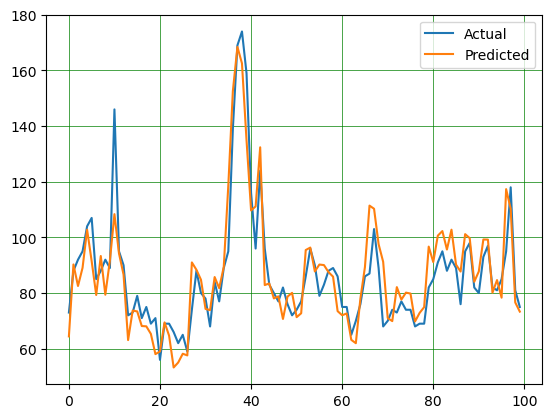

In [155]:
df1 = pd.DataFrame({'Actual': y_test[50:150].flatten(), 'Predicted': y_prediction[50:150].flatten()})
df1.plot(kind='line')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### 预测模型总结
> + **从三种模型曲线的拟合程度上来看，三种模型都有较好的表现，说明通过时间序列来预测AQI是科学的。**
>+ **从三种模型的决定系数、均方误差、均方根误差、平均绝对误差指标来看，这三种模型在给定的任务中表现相当，并且没有明显的优劣之分。选择最适合的模型可能需要考虑具体的应用场景、模型的解释性以及其他因素。在实际应用中，建议进行进一步的交叉验证和模型调优，以确保模型在不同数据集上的性能稳定。**
